#  COMP24112 Lab 2: News Article Classification by k-NN

## 1. Task description

You will work on a news article classification task.
The provided dataset includes a total of 800 articles taken from Reuters newswire.
They belong to 4 classes: "earn" (0), "crude" (1), "trade" (2) and "interest" (3).
There are 200 articles per class.
Each article is characterised by word occurrences.
The list of used words is called a vocabulary.
In our dataset, the vocabulary includes a total of 6428 words. 

## 2. Preparation

First we need to import the data.
Run the below cell to load the data using NumPy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

data, labels, class_names, vocabulary = np.load("ReutersNews_4Classes_sparse.npy", allow_pickle=True)

### A Note on Sparsity

Most documents only contain a small subset of the vocabulary, resulting in a very sparse data matrix.
To handle the sparsity, in this exercise `data` is represented as a `scipy.sparse.csr_matrix`, which can store sparse matrices efficiently while still allowing efficient row-based indexing.
You can learn more about `csr_matrix` and other ways of dealing with sparse matrices at https://docs.scipy.org/doc/scipy/reference/sparse.html.

Note, however, that `data` is **not** a normal NumPy array.
While most operations will be the same as with a normal dense array, **you cannot use a sparse matrix to index another matrix**.
If you need to do this, either first convert the matrix to a NumPy array with the `toarray()` method, or use methods specifically designed to work with sparse matrices.

In [2]:
print(data[41,:]) # A sparse row vector; the output will be the non-zero indices and their values.
print(data[41,:].toarray()) # Convert back to a NumPy array. Note that the result is a (1, 6428) matrix, not a vector.
# print(vocabulary[data[41,:] > 0]) # Can't index vocabulary with a sparse matrix.
rows, columns, values = scipy.sparse.find(data[41,:]) # Find the non-zero entries in the 42nd document.
print(vocabulary[columns]) # Prints the words present in the 42nd document.

  (0, 2)	1
  (0, 3)	3
  (0, 5)	1
  (0, 8)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 21)	2
  (0, 24)	1
  (0, 105)	1
  (0, 127)	1
  (0, 227)	1
  (0, 275)	1
  (0, 334)	2
  (0, 341)	1
  (0, 348)	1
  (0, 359)	1
  (0, 411)	1
  (0, 426)	1
  (0, 1428)	1
  (0, 2058)	1
  (0, 5555)	1
[[0 0 1 ... 0 0 0]]
['share' 'split' 'say' 'two-for-one' 'shareholder' 'annual' 'meeting'
 'reuter' 'ct' 'note' 'company' 'pay' 'subject' 'increase' 'stock'
 'dividend' 'april' 'northern' 'declare' 'approval' 'telecom' 'post-split'
 'nt']


To see the full vocabulary, you can run

In [3]:
print(", ".join(vocabulary))

island, telephone, share, split, approve, say, previously, announce, two-for-one, common, shareholder, annual, meeting, reuter, year, net, shr, loss, nil, vs, profit, ct, rev, mln, note, current, include, charge, discontinue, operation, dlr, ec, state, tax, majority, european, community, member, strong, reservation, import, domestically-produced, oil, fat, propose, commission, senior, diplomat, special, committee, agricultural, expert, voice, objection, measure, prepare, ground, farm, begin, monday, add, france, italy, indicate, support, proposal, lead, initially, tonne, 1987/88, price, round, complete, sale, french, unit, business, compagnie, francaise, group, investor, employee, minnesota, disclose, term, deal, plan, asset, electronic, shoe, town, end, jan, respectively, december, wisconsin, fwb, buy, bank, corp, acquire, bancshare, cash, acquisition, hold, company, total, billion, purchase, time, earning, office, paul, area, american, product, 3rd, qtr, period, feb, mth, avg, 4th, s

You can see how many times article $i$ contains word $j$ using

In [4]:
i, j = 40, 2
print(data[i,j])

4


You can see which class the $i$th article belongs to using

In [5]:
print(labels[i])

0


For instance, by running

In [6]:
print("Occurrences:", data[0,10])
print("Class:", class_names[labels[0]])
print("Word:", vocabulary[10])

Occurrences: 2
Class: earn
Word: shareholder


you can see that the 11th word appears twice in the first document, the first document belongs to the class "earn", and the 11th word is "shareholder".

The following function randomly selects a subset of the data.

In [7]:
def sample_indices(labels, *num_per_class):
    """
    Returns randomly selected indices. It will return the specified number of indices for each class.
    """
    indices = []
    for cls, num in enumerate(num_per_class):
        cls_indices = np.where(labels == cls)[0]
        indices.extend(np.random.choice(cls_indices, size=num, replace=False))
    return np.array(indices)

For instance, to get one sample from the first class, two from the second, three from the third, and four from the fourth, you can run:

In [8]:
indices = sample_indices(labels, 1, 2, 3, 4)
print("Returned indices:", indices)
print("Samples:", data[indices])
print("Corresponding classes:", labels[indices])

Returned indices: [177 397 258 413 510 542 638 635 685 754]
Samples:   (0, 2)	1
  (0, 3)	1
  (0, 8)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	3
  (0, 16)	4
  (0, 19)	8
  (0, 21)	3
  (0, 22)	2
  (0, 23)	11
  (0, 24)	1
  (0, 30)	1
  (0, 117)	1
  (0, 121)	2
  (0, 122)	1
  (0, 601)	1
  (0, 1097)	1
  (0, 2555)	1
  (0, 6348)	1
  (1, 5)	7
  (1, 13)	1
  (1, 20)	1
  (1, 25)	1
  (1, 33)	5
  :	:
  (8, 1229)	4
  (8, 1426)	1
  (8, 1600)	2
  (8, 1838)	2
  (8, 1950)	1
  (8, 2387)	1
  (8, 2389)	1
  (8, 2619)	1
  (8, 5089)	1
  (9, 5)	1
  (9, 13)	1
  (9, 98)	2
  (9, 215)	1
  (9, 285)	1
  (9, 332)	3
  (9, 340)	2
  (9, 377)	1
  (9, 382)	2
  (9, 441)	1
  (9, 814)	1
  (9, 984)	2
  (9, 1229)	2
  (9, 1539)	1
  (9, 1588)	1
  (9, 4133)	1
Corresponding classes: [0 1 1 2 2 2 3 3 3 3]


## 3. k-NN Implementation (4 Marks, Normal)

Now, you will need to implement a k-NN classifier by filling the code below.
This function should support two types of distance measures: Euclidean distance and cosine distance (defined as 1 - cosine similarity). It should take a set of training samples, a user-specified neighbour number, a distance option, and features of a set of testing samples as the input.
It should return the predicted classes for the input set of testing samples.

In order to get 4 marks, you are asked to implement the k-NN classifier from scrach without relying on any machine learning library, particularly the distance calculation. But you are allowed to research NumPy functions relating to sorting. If you decide to use existing distance implementation from libraries, e.g., `sklearn.metrics.pairwise_distances` imported as `cdist`, you can get at most 3 marks.

**Your implementation must NOT make use of Python loops over individual samples or features**.
You should use functions that operate on whole matrices, as this will be much faster than looping in Python.
Each experiment below is expected to take no more than 2 minutes to run.

In [9]:
import scipy.stats
from sklearn.metrics import pairwise_distances as cdist


def knn_classify(test_samples, training_data, training_labels, metric="euclidean", k=1):
    """
    Performs k-nearest neighbour classification on the provided samples,
    given training data and the corresponding labels.
    
    test_samples: An m x d matrix of m samples to classify, each with d features.
    training_data: An n x d matrix consisting of n training samples, each with d features.
    training_labels: A vector of size n, where training_labels[i] is the label of training_data[i].
    metric: The metric to use for calculating distances between samples.
    k: The number of nearest neighbours to use for classification.
    
    Returns: A vector of size m, where out[i] is the predicted class of test_samples[i].
    """
    # Calculate an m x n distance matrix.
    if metric == "euclidean":
        x_square = test_samples.multiply(test_samples).sum(1)
        y_square = training_data.multiply(training_data).sum(1).T
        two_xy =  2 * test_samples.dot(training_data.T)
        pairwise_distance = np.sqrt(x_square + y_square - two_xy)
    elif metric == "cosine":
        x_y_transpose = test_samples.dot(training_data.T).toarray()
        x_cos_distance = np.sqrt(test_samples.multiply(test_samples).sum(1))
        y_cos_distance = np.sqrt(training_data.multiply(training_data).sum(1).T)
        x_y_length = x_cos_distance.dot(y_cos_distance)
        cos_similarity = np.divide(x_y_transpose, x_y_length)
        pairwise_distance = 1 - cos_similarity
    else:
        raise ValueError("Unsupported distance metric")

    # Find the k nearest neighbours of each sample as an m x k matrix of indices.
    nearest_neighbours = np.argsort(pairwise_distance, axis=1)[:, :k]

    # Look up the classes corresponding to each index.
    nearest_labels = training_labels[nearest_neighbours]

    # Return the most frequent class on each row.
    # Note: Ensure that the returned vector does not contain any empty dimensions.
    # You may find the squeeze method useful here.
    return np.squeeze(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=nearest_labels))

## 4. Experiments (13 Marks in Total)

Use your k-NN function to perform the following experiments.

### Experiment 1 (3 Marks, Easy)

Randomly select 80 articles per class for training, and use the remaining articles for testing.
Fix a neighbour number setting as you see fit. Perform k-NN classification using the Euclidean distance and test it.

Repeat this process 20 times (trials).
Calculate the mean and standard deviation of the testing accuracies. Print out the mean and standard deviation.

In [10]:
# Your code goes here

training_articles = []
testing_articles = []
result = []
accuracy = []

# Process repeated 20 times
for x in range(20):
    
    # Stores the indices for training in an array, then gets the articles at these indices
    training_indices = sample_indices(labels, 80, 80, 80, 80)
    training_articles = data[training_indices]

    # Stores the indices for tetsing in an array by calculating the set difference, then gets
    # the articles at these indices
    testing_indices = np.setdiff1d(np.arange(800), training_indices)
    testing_articles = data[testing_indices]

    # Stores the labels of each of the articles in an array
    training_labels = labels[training_indices]
    testing_labels = labels[testing_indices]
    
    # Sets metric to euclidean, and k to 4 so our classifier would be 4-NN
    metric = "euclidean" 
    k = 3

    result = knn_classify(testing_articles, training_articles, training_labels, metric, k)

    # Compares all the labels from what the classifier returned vs the correct labels, 
    # if the labels are equal that means they are correctly classified, therefore TRUE 
    # is returned and all the TRUE values are added up
    correctly_classified = np.count_nonzero(result == testing_labels)

    # The accuracy for the classifier is calculated and stored in an array for all 20 values
    accuracy = np.append(accuracy, (correctly_classified / 480) * 100)

print("k-NN with Euclidean distance")
print("The mean of the testing accuracies is: ", np.mean(accuracy))
print("The standard deviation of the testing accuracies is: ", np.std(accuracy))

k-NN with Euclidean distance
The mean of the testing accuracies is:  87.88541666666666
The standard deviation of the testing accuracies is:  1.791272970310964


Use the same neighbour number, but use the cosine distance instead of the Euclidean distance.
Repeat the same experiment.

Print out the mean and standard deviation.

In [11]:
# Your code goes here
training_articles = []
testing_articles = []
result = []
accuracy = []

for x in range(20):

    # Stores the indices for training in an array, then gets the articles at these indices
    training_indices = sample_indices(labels, 80, 80, 80, 80)
    training_articles = data[training_indices]

    # Stores the indices for tetsing in an array by calculating the set difference, then gets
    # the articles at these indices
    testing_indices = np.setdiff1d(np.arange(800), training_indices)
    testing_articles = data[testing_indices]

    # Stores the labels of each of the articles in an array
    training_labels = labels[training_indices]
    testing_labels = labels[testing_indices]
    
    # Cosine distance is used instead
    metric = "cosine" 
    k = 3

    result = knn_classify(testing_articles, training_articles, training_labels, metric, k)

    # Calculates correctly classified labels
    correctly_classified = np.count_nonzero(result == testing_labels)

    # Calculates accuracy and stores in an array
    accuracy = np.append(accuracy, (correctly_classified / 480) * 100)

print("k-NN with Cosine distance")   
print("The mean of the testing accuracies is: ", np.mean(accuracy))
print("The standard deviation of the testing accuracies is: ", np.std(accuracy))

k-NN with Cosine distance
The mean of the testing accuracies is:  96.07291666666667
The standard deviation of the testing accuracies is:  0.6154654686134357


Explain in your report which distance measure gives better performance and analyse the reason. 

### Experiment 2 (5 Marks, Easy)

Using the distance measure that you found performs better in Experiment 1.

Randomly select 80 articles per class for training, and use the remaining articles for testing. Perform k-NN classification with the neighbour number $k$ varying from 1 to 50.

For each values of $k$, repeat the training process by 20 trials and record the average training error rates and standard deviation.

Do the same for testing errors.

In [12]:
# Your code goes here
training_articles = []
testing_articles = []

training_result = []
testing_result = []

train_err_mean = []
test_err_mean = []
train_err_std = []
test_err_std = []

for k in range(1,51):
    
    training_error = []
    testing_error = []
    
    for x in range(20):

        # Stores the indices for training in an array, then gets the articles at these indices
        training_indices = sample_indices(labels, 80, 80, 80, 80)
        training_articles = data[training_indices]

        # Stores the indices for tetsing in an array by calculating the set difference, then gets
        # the articles at these indices
        testing_indices = np.setdiff1d(np.arange(800), training_indices)
        testing_articles = data[testing_indices]

        # Storing the labels for training and testing data in an array
        training_labels = labels[training_indices]
        testing_labels = labels[testing_indices]
        metric = "cosine" 
        
        # Gets the result from the classifier, the first line compares the training articles against 
        # themselves and classifies them again. The second line compares tetsing data with training
        training_result = knn_classify(training_articles, training_articles, training_labels, metric, k)
        testing_result = knn_classify(testing_articles, training_articles, training_labels, metric, k)

        # Counts what has been correctly classified from each result
        correctly_classified_train = np.count_nonzero(training_result == training_labels)
        correctly_classified_test = np.count_nonzero(testing_result == testing_labels)

        # Counts the incorrectly classified, this will be used to calculate error
        wrongly_classified_train = 320 - correctly_classified_train
        wrongly_classified_test = 480 - correctly_classified_test
        
        # For each trial, value of error is stored in an array, making it easier to calculate mean
        training_error = np.append(training_error, (wrongly_classified_train / 320))
        testing_error = np.append(testing_error, (wrongly_classified_test / 480))
    
    # Calculates average error value, these values are used for the graph
    train_err_mean = np.append(train_err_mean, np.mean(training_error))
    test_err_mean = np.append(test_err_mean, np.mean(testing_error))
    
    # Calculates standard deviation of accuracy
    train_err_std = np.append(train_err_std, np.std(training_error))
    test_err_std = np.append(test_err_std, np.std(testing_error))
    
    
    

Produce an error bar plot showing the training error rate for each $k$ here:

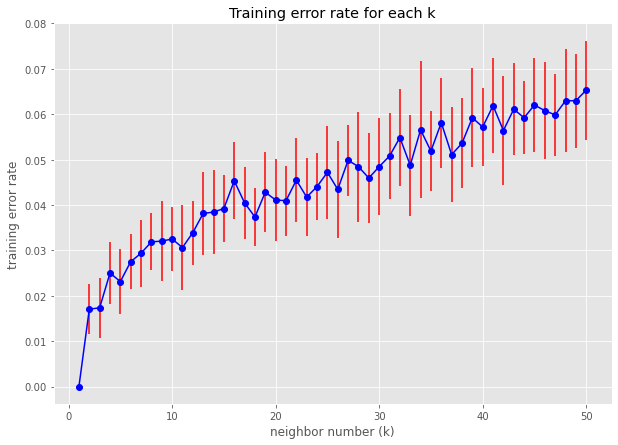

In [13]:
# Your code goes here
plt.style.use("ggplot")
plt.figure(figsize=(10, 7))
plt.title("Training error rate for each k")

x = np.arange(1,51)
plt.xlabel('neighbor number (k)')

# Plots the mean training error value for each k
y = train_err_mean
plt.ylabel('training error rate')

# Error bar is proportional to standard deviation
y_err = train_err_std

plt.errorbar(x, y, yerr=y_err, ecolor='r', color='b', fmt='-o')
plt.show()

Produce your testing error bar plot here:

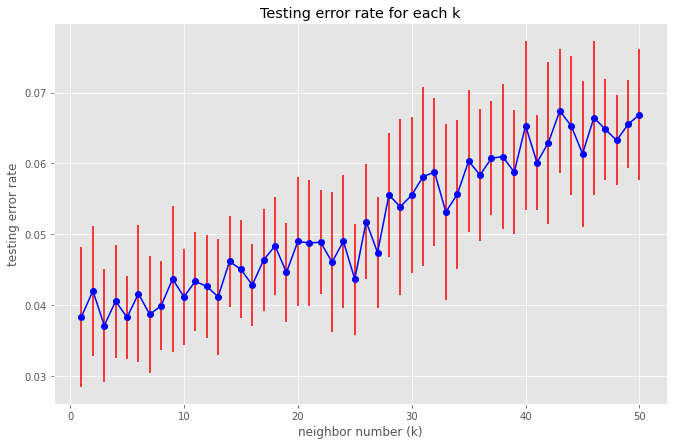

In [14]:
# Your code goes here
plt.style.use("ggplot")
plt.figure(figsize=(11, 7))
plt.title("Testing error rate for each k")
# k values vary from 1 to 51
x = np.arange(1,51)
plt.xlabel('neighbor number (k)')

# Plots the mean testing error value for each k
y = test_err_mean
plt.ylabel('testing error rate')

# Error bar is proportional to standard deviation
y_err = test_err_std
           
plt.errorbar(x, y, yerr=y_err, ecolor='r', color='b', fmt='-o')
plt.show()

**Remember that all graphs should have axis labels and a title.**

Discuss in your report the difference between the training and testing accuracies, and why this is the case. 

Analyse in your report the effect of $k$ based on this experiment. What do you think is a reasonable value for $k$? Comment specifically on the *bias* and *variance* of your model at small and large values of $k$.

### Experiment 3 (5 Marks, Hard)

In this experiment we will create confusion matrices for a more detailed view on our model's performance. Then, we will observe the behaviour of our knn classifier on novel classes.

First, randomly select 100 articles per class for training, and use the remaining articles for testing. Set the neighbour number to $k=3$. Perform 3-NN classification using the Cosine distance, as in previous experiments.

#### Confusion Matrix Implementation  

Implement a multi-class confusion matrix yourself, from scratch. Let the row index correspond to the known label, and column index to predicted label. If you decide to use existing confusion matrix implementation from libraries, e.g., `sklearn.metrics.confusion_matrix`, you can get at most 4 marks. (However, you may use an existing implementation to check the output of your own function.)

Print out the confusion matrix and overall accuracy of your classifier for the testing data.

In [15]:
testing_articles = []
training_articles = []
training_result = []


# Randomly selects 100 indices from each class, which are the used to get the
# data and labels
training_indices = sample_indices(labels, 100, 100, 100, 100)
training_articles = data[training_indices]
training_labels = labels[training_indices]

testing_indices = np.setdiff1d(np.arange(800), training_indices)
testing_articles = data[testing_indices]
testing_labels = labels[testing_indices]

metric = "cosine" 
k = 3

# Classifier is run which gets the most common class for each testing indices
testing_result = knn_classify(testing_articles, training_articles, training_labels, metric, k)
indices  = list(range(400))
confusion_matrix = np.zeros((4, 4))
for i in range(0,4):
  for j in range(0, 4):
    # for each position i,j counting how many elements (1) are from the actual testing set have the label i and
    # (2) are from the predicted set and have label j
    confusion_matrix[i][j] = sum(map(lambda k: testing_labels[k] == i and testing_result[k] == j, indices))
confusion_matrix = confusion_matrix.astype(int)
print("The confusion matrix for the 4 classes is: ")
print(confusion_matrix)
print("\nThe overall accuracy of the classifier is: ", np.trace(confusion_matrix) / 4)
  


The confusion matrix for the 4 classes is: 
[[96  1  2  1]
 [ 3 93  3  1]
 [ 1  1 97  1]
 [ 0  1  3 96]]

The overall accuracy of the classifier is:  95.5


#### On Novel Classes

5 new articles have been provided in string format below. The code to create a sparse representation of these articles has also been provided. Take a moment to skim through the articles.

Run the code below, saving the sparse matrix representation of these 5 articles into `new_data`.

In [16]:
sp0 = """World number four Jessica Pegula said she thought about ending her tennis career prematurely last year due to her mother Kim's health issues.
Kim, the co-owner and president of the NFL's Buffalo Bills and NHL's Buffalo Sabres, suffered a cardiac arrest in June and needed CPR from her other daughter Kelly before paramedics arrived and restored her heartbeat.
Pegula received the news after returning home to Florida from the French Open, where she lost to eventual champion Iga Swiatek but rose to number eight in the world.
"Suddenly I went from, 'Let's celebrate top 10 in the world' to, 'Do I need to start thinking about my career after tennis a lot sooner than I thought?'" Pegula wrote in an essay in The Players' Tribune.
"I'm 28 and I take pride in being able to handle every situation thrown at me, but this was a lot."
Pegula said she wanted to share her mother's story after Bills safety Damar Hamlin suffered a cardiac arrest during an NFL game last month.
Pegula went on to play Wimbledon and the U.S. Open last year to reach a career-high ranking of number three.
"I still wanted to play Wimbledon if I knew my mom was O.K.," Pegula wrote. "My dad didn't want me to play, but I knew she would be upset if I skipped because of her.
"I had to deal with a lot of speculation and questions surrounding her health, even shutting down rumours that she had died," added Pegula, who lost to Victoria Azarenka in the quarter-finals of this year's Australian Open.
"It wasn't necessarily the most fun Wimbledon experience I remember. I had a few good wins, and I was proud I was able to go out and compete considering the situation." """

sp1 = """Juventus outclassed Salernitana 3-0 on Tuesday in Serie A, with two goals and one assist from striker Dusan Vlahovic helping the visitors move up to 10th place in the standings. The game marked a return to form for Serbian Vlahovic, who has struggled with injuries this season, but made his first league start since October. 
"You can see physically, he just moves better, looks sharper, he also played well on a technical level today," Juventus manager Massimiliano Allegri told DAZN.
Juventus got a penalty after 26 minutes when Hans Nicolussi fouled Manuel Locatelli inside the box with Vlahovic converting the penalty.
Vlahovic almost netted a second in the 37th minute, but his shot from an acute angle at the edge of the box went just wide of the post.
Filip Kostic doubled the lead on the stroke of halftime when he tapped the ball in from close range after Vlahovic's initial shot bounced into his path, providing an unintended assist.
Juventus could have scored a third in the last seconds before the break when Locatelli made a run unmarked into the box, but Salernitana keeper Guillermo Ochoa reacted early and parried his attempted lob.
Vlahovic got his second goal 80 seconds into the second half when he ran through in the box and smashed the ball low into the right corner.
Salernitana almost pulled one back in the 51st minute, with Junior Sambia sending a cross that went through almost everyone in the box, but forward Boulaye Dia was unable to stretch himself in time to guide the ball into the open net.
"The team gave a strong response, we had a good 60 minutes, but got a bit complacent after going 3-0 up and allowed too many shots on goal. We were static in our positions, didn't move around enough and the players know we must absolutely do better," Allegri said.
"The first 10 minutes we tended to pass it too much down the right, so we need to improve our passing, be smoother and keep it simple."
Juve could have added to their tally but were denied by the woodwork with Angel Di Maria hitting the crossbar after 53 minutes and Moise Kean striking the post late on.
The result moved Juventus on to 26 points from 21 matches, while Salernitana are 16th with 21 points." """

sp2 = """Manchester United manager Erik ten Hag said he has a long-term plan to build a culture and to develop players at the club.
United appointed Ten Hag in April 2022 to succeed interim boss Ralf Rangnick.
The team sit third in the Premier League, eight points behind leaders Arsenal, and have the chance to win their first trophy since 2017 when they face Newcastle United in the League Cup final on Feb. 26.
"I always think about the long term, in every club where I was, I have been thinking about long-term work to build a culture, to build a way of playing, to develop the players and the team, obviously," Ten Hag told reporters.
"I think in the long term obviously in contracts and in (transfer) windows because I think that is the (right) way.
"I am not here for one year, I am (here for) longer, I see it is a long-term project to build here and how long it is you can't see, I can't tell," he added."""

sp3 = """A near-historic Philadelphia Eagles pass rush will face the ultimate test on Sunday in Kansas City Chiefs quarterback Patrick Mahomes, an MVP favourite with no interest in ceding the Super Bowl spotlight.
The Eagles established themselves as a terrifying defensive force in the regular season, punishing opponents with an astonishing 70 sacks, two shy of the NFL record, while allowing the second-fewest yards per game.
But Mahomes is unlike any quarterback they faced in 2022.
"Mahomes is the guy that extends the plays and drops the dimes," defensive end Brandon Graham, who helped the Eagles to the Lombardi Trophy five years ago, told reporters on Tuesday.
"You've got to make sure you can hit him, get him on the ground, create turnovers, make him make bad throws."
At just 27-years-old Mahomes has already vaulted himself into the history books, joining future Hall of Famer Drew Brees this year as one of only two quarterbacks to throw for more than 5,000 yards and 40 or more touchdowns in multiple seasons.
Eagles linebacker Haason Reddick produced a career-best 16 sacks this season but had few answers when asked how the Eagles could contain Mahomes.
"When it comes to Patrick Mahomes, man, he's a tremendous talent," he told reporters this week.
"I don't know if you can contain him - I just don't know, he's that good. I won't lie, he is."
Not even injury appeared to hold back Mahomes in the postseason, when he played in the AFC title match against the Cincinnati Bengals just eight days after suffering a high ankle sprain in the Chiefs' divisional round win.
With the game tied and seconds left on the clock in the fourth quarter, he produced a heroic sprint that ultimately helped put kicker Harrison Butker within range.
"I know he was hurting - I know that. He's so mentally tough," head coach Andy Reid told reporters at the Super Bowl Opening Night on Monday. "That run that he made at the end, that was the fastest he's run all year."
Cornerback James Bradberry said that it would take everything in the Eagles arsenal to stop Mahomes from collecting his second Super Bowl ring.
"You just have to be aware of how dominant he can be. You want to make sure you can contain him, eliminate what he's able to do," he told reporters on Tuesday.
"You just want to make sure you put guys in his face. That's what our defensive line has been doing all year." """

sp4 = """Los Angeles Lakers forward LeBron James surpassed Kareem Abdul-Jabbar to become the NBA's all-time leading scorer on Tuesday, setting the new mark with a fadeaway jumpshot late in the third quarter of a home game against the Oklahoma City Thunder.
'King James', who entered the game needing 36 points to break Abdul-Jabbar’s record of 38,387, sent the sold-out crowd into a frenzy when the ball splashed through the net, raising his arms in triumph as his team mates embraced him.
Lakers great Abdul-Jabbar, who took the title from Wilt Chamberlain with his signature skyhook on April 5, 1984, sat courtside at Tuesday's game and stood to applaud James after the record was broken.
Play was stopped to recognize the achievement and to let James address the crowd.
"I just want to say thank you to the Laker faithful, you guys are one of a kind," James said.
"To be able to be in the presence of such a legend as Kareem is unbelievable, it's very humbling. Please give a standing ovation to 'The Captain.'"
Tributes from his family, U.S. President Joe Biden and students from his "I Promise School" were played inside the arena, while NBA Commissioner Adam Silver told Reuters it was an "historic moment".
"These types of significant milestones capture the attention of not only basketball fans but broader society," Silver said.
"LeBron's pursuit of the scoring record is no exception and billions of people will become aware of this milestone."
All season long it has been a question of when, not if, James would topple the record. Some thought it may come during Thursday's home game against Milwaukee but James had other ideas.
Arriving at the arena in a jet black suit, black shirt and dark sunglasses, James looked like he was going to a funeral.
Hours later, he buried Abdul-Jabbar's record.
A deafening roar greeted him during the pre-game introductions and another came when he buried a three-pointer five minutes into the opening quarter for his first points of the night.
He cut the number he needed to single digits on a straightway three in the second half that sent fans leaping from their seats before the 21-foot, history-making bucket arrived with 10 seconds remaining in the third quarter.
"It's so surreal, because it's something I never made a goal of mine or something I set out to do," James said after the game. "It just happened."
Drafted into the league as a teenager, the Akron, Ohio native has more than delivered on the massive expectations put on his broad shoulders at a young age.
A versatile forward, he helping usher in the era of position-less basketball, winning four titles with three different teams, four MVP awards and four Finals MVP awards.
James sits top of the regular season points list followed by Abdul-Jabbar with Utah Jazz great Karl Malone (36,928), late Lakers legend Kobe Bryant (33,643) and Chicago Bulls icon Michael Jordan (32,292) rounding out the top five.
"When I read about the history of the game I never thought that this record would ever be touched," James said.
"I just didn't think nobody would have that type of longevity to come out on the floor and play at that level for so long.
"So it's just a complete honor to be a part of this league, to be a part of some of the greats that have ever played this game and to be right at the apex with them."
Last month, the 38-year-old was named to a record-tying 19th All Star game, a mark also held by Abdul-Jabbar.
"For sure I know I can play a couple more years," James said.
"The way I'm feeling, the way my body has been reacting to me throughout the course of this season, I know I can play a couple more years.
"It's all about my mind. My mind is still into it and I am still motivated to go out and try to compete for championships because I feel like that's what I can still do."
Despite James' historic night, the Lakers fell 133-130 to the Thunder and are now 25-30 on the season."""

In [17]:
# Make sure you have scikit-learn installed. 
from sklearn.feature_extraction.text import CountVectorizer

articles = []
for f in [sp0, sp1, sp2, sp3, sp4]:
    text = f.replace('\n', ' ')
    articles.append(text)
vrizer = CountVectorizer(vocabulary=vocabulary)
new_data = vrizer.fit_transform(articles)

(1) Run the classifier from step (1) to predict the classes of the articles in `new_data`. Print out the class predictions.

What classes to you think these 5 articles should belong to, based on your own judgement of their content? Can your classifer make an appropriate class prediction for these 5 articles? Analyse the reason for your answers in your report.

In [18]:
# Your code goes here
predictions = knn_classify(new_data, data, labels, metric="cosine", k=3)
print("Predicted classes for new data:", predictions)


Predicted classes for new data: [1 1 3 2 0]


(2) Introduce a new class, `sport`, to your dataset. The class should contain the 5 articles as above. Add this to your data using the command below. Your new data contains 805 articles, 800 from the original dataset and 5 from the `new_data`, belonging to 5 classes: 200 articles from each of the first 4 classes and 5 articles from the 5th class.

Randomly split the new data into a training set containing **100 articles each from 'earn', 'crude', 'trade', and 'interest', and then only 3 articles from 'sport'** (you should be able to use the `sample_indices` function given at the start). Reserve the remaining articles for testing. Test the performance of the new 3-NN classifier.

Print the confusion matrix and classification accuracy for the testing data.

In [19]:
data_augmented = scipy.sparse.vstack((data, new_data))
labels_augmented = np.concatenate([labels, [4,4,4,4,4]])
from sklearn.metrics import confusion_matrix



testing_articles = []
training_articles = []
training_result = []

# Randomly selects 100 indices from each class, which are the used to get the
# data and labels
training_indices = sample_indices(labels_augmented, 100, 100, 100, 100, 3)
training_articles = data_augmented[training_indices]
training_labels = labels_augmented[training_indices]

testing_indices = np.setdiff1d(np.arange(805), training_indices)
testing_articles = data_augmented[testing_indices]
testing_labels = labels_augmented[testing_indices]

metric = "cosine" 
k = 3

# Classifier is run which gets the most common class for each testing indices

testing_result = knn_classify(testing_articles, training_articles, training_labels, metric, k)

indices  = list(range(len(testing_indices)))
confusion_matrix = np.zeros((5, 5))
for i in range(0,5):
  for j in range(0, 5):
    # for each position i,j counting how many elements (1) are from the actual testing set have the label i and
    # (2) are from the predicted set and have label j
    confusion_matrix[i][j] = sum(map(lambda k: testing_labels[k] == i and testing_result[k] == j, indices))
confusion_matrix = confusion_matrix.astype(int)
print("The confusion matrix for the 5 classes is: ")
print(confusion_matrix)
print("\nThe overall accuracy of the classifier is: ", (np.trace(confusion_matrix) / np.sum(confusion_matrix))*100)




The confusion matrix for the 5 classes is: 
[[94  2  3  1  0]
 [ 2 95  1  2  0]
 [ 1  0 97  2  0]
 [ 0  1  2 97  0]
 [ 0  1  1  0  0]]

The overall accuracy of the classifier is:  95.27363184079603


(3) Repeat the above process 6 times, repeating the random train-test split. For each of the 5 classes, print out its averaged testing accuracy. Comment on your classifier's performance in your report. What are the consequences of having no training data and limited training data for the 'sports' class? 

In [20]:

# Create lists to store the accuracy for each iteration
acc_0 = []
acc_1 = []
acc_2 = []
acc_3 = []
acc_4 = []
# repeat 6 times
for i in range(6):
    # Randomly selects 100 indices from each class, which are the used to get the
    # data and labels
    training_indices = sample_indices(labels_augmented, 100, 100, 100, 100, 3)
    training_articles = data_augmented[training_indices]
    training_labels = labels_augmented[training_indices]

    testing_indices = np.setdiff1d(np.arange(805), training_indices)
    testing_articles = data_augmented[testing_indices]
    testing_labels = labels_augmented[testing_indices]

    metric = "cosine" 
    k = 3

    # Classifier is run which gets the most common class for each testing indices

    testing_result = knn_classify(testing_articles, training_articles, training_labels, metric, k)

    indices  = list(range(len(testing_indices)))
    confusion_matrix = np.zeros((5, 5))
    for i in range(0,5):
        for j in range(0, 5):
            # for each position i,j counting how many elements (1) are from the actual testing set have the label i and
            # (2) are from the predicted set and have label j
            confusion_matrix[i][j] = sum(map(lambda k: testing_labels[k] == i and testing_result[k] == j, indices))
    confusion_matrix = confusion_matrix.astype(int)

    # Calculate the accuracy for each class
    acc_0.append(confusion_matrix[0][0] / np.sum(confusion_matrix[0]))
    acc_1.append(confusion_matrix[1][1] / np.sum(confusion_matrix[1]))
    acc_2.append(confusion_matrix[2][2] / np.sum(confusion_matrix[2]))
    acc_3.append(confusion_matrix[3][3] / np.sum(confusion_matrix[3]))
    acc_4.append(confusion_matrix[4][4] / np.sum(confusion_matrix[4]))

# Print the averaged accuracy for each class
print("Average testing accuracy for earn class:", np.mean(acc_0)*100)
print("Average testing accuracy for crude class:", np.mean(acc_1)*100)
print("Average testing accuracy for trade class:", np.mean(acc_2)*100)
print("Average testing accuracy for interest class:", np.mean(acc_3)*100)
print("Average testing accuracy for sports class:", np.mean(acc_4)*100)


Average testing accuracy for earn class: 96.66666666666667
Average testing accuracy for crude class: 96.33333333333333
Average testing accuracy for trade class: 96.66666666666667
Average testing accuracy for interest class: 97.66666666666666
Average testing accuracy for sports class: 58.333333333333336


(4) Self-learn the concepts of zero-shot learning and few-shot learning. In your report, link these concepts to the experiments you've just performed. Is your model performing zero- or few-shot learning? Explain your reasoning. 

## 5. Result Analysis (4 Marks in Total)

### Analysis 1 (2 Marks, Normal)
Choose a training-testing trial in Experiment 2 for $k=1$. Observe the testing error of this 1-NN, and estimate the interval where its true error lies with 90% probability. Explain in your report how you compute it.

In [21]:
# You may write your calculations in LateX or in code here
# choose a training-testing trial in experiment 2 for k = 1.
# Sample size, use Z distribution
n = 480
# the value of zp corespondent to the probabilty of 90% in the table
z = 1.64
# Retrieve the testing error for the chosen trial
error_sample = test_err_mean[0]
print("The mean of the trial errors is " + str(error_sample))
print("The STD of the trial errors is " + str(test_err_std[0]))

k1_std_approx = test_err_mean[0]*(1-test_err_mean[0])

# calculate alpha 
alpha = z * np.sqrt(k1_std_approx)/np.sqrt(n)
# estimate its interval
print("The interval is between " + str(error_sample - alpha) + " and " + str(error_sample + alpha))

The mean of the trial errors is 0.038333333333333344
The STD of the trial errors is 0.009868932735272512
The interval is between 0.0239611150839674 and 0.05270555158269929


### Analysis 2 (2 Marks, Normal)
The following function `Get_p_value()` is provided to obtain $p$ according to $z_p$. Use this function to perform Analysis 2.

In [22]:
# run this cell first

def Get_p_value(zp):
    return round(1 - scipy.stats.norm.sf(abs(zp))*2,2)

In [23]:
# Use this cell to compare the output value of function Get_p_value with 
# the table provided in your lecture notes (e.g., Slide 12, Chapter3C.pdf)

print('zp = 0.67, p = ', Get_p_value(0.67))
print('zp = 1, p = ', Get_p_value(1))
print('zp = 1.64, p = ', Get_p_value(1.64))
print('zp = 2.58, p = ', Get_p_value(2.58))
print()

# you can alert the input zp value and re-run this cell to help you to calculate the corresponding p.
print('p = ', Get_p_value(0.43))  


# you can change 0.43 to any zp value you obtained.

zp = 0.67, p =  0.5
zp = 1, p =  0.68
zp = 1.64, p =  0.9
zp = 2.58, p =  0.99

p =  0.33


Choose a training-testing trial in Experiment 2 for k=45. Observe the testing error of this 45-NN. Compare it with the 1-NN in Analysis 1. Which one has higher testing sample error? Estimate the probability that it also has higher true error. Explain your answer and how you compute it in the report.  

In [24]:
# Retrieve the testing error for the 45-NN trial in Experiment 2
error_sample_45 = test_err_mean[44]
print("The mean of the trial errors is " + str(error_sample_45))
print("The STD of the trial errors is " + str(test_err_std[44]))

print("1-NN sample error: ", np.around(error_sample, 4))
print("45-NN sample error: ", np.around(error_sample_45, 4))

if (error_sample > error_sample_45):
  print("1-NN has a higher testing sample error")
else:
  print("45-NN has a higher testing sample error")

# compute approximation of std for k = 45
k45_std_approx = test_err_mean[44]*(1-test_err_mean[44])
# calculate alpha value
alpha_45= z * np.sqrt(k45_std_approx)/np.sqrt(n)

d = abs(error_sample - error_sample_45)
sigma = np.sqrt(error_sample * (1 - error_sample) / 480 + error_sample_45 * (1 - error_sample_45) / 480)
zp = d / sigma
C = 1 - (1 - Get_p_value(zp)) / 2

print("The probability that 45-NN has the higher true error is ", np.around(C, 3))



The mean of the trial errors is 0.061354166666666654
The STD of the trial errors is 0.010342968458222126
1-NN sample error:  0.0383
45-NN sample error:  0.0614
45-NN has a higher testing sample error
The probability that 45-NN has the higher true error is  0.95


## 6. Hyperparameter Selection (4 Marks, Normal)

Use your k-NN function with cosine distance. Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. In this case, your hyperparameter will be $k$. You can choose from the random subsampling, k-fold CV and LOO approaches for hyperparameter selection. In order to get 4 marks, you should implement this from scrach without using readily implemented data-split functions provided in existing libraries. If you decide to use existing implementation on data splitting, model selection and/or evaluation, you can get at most 2 marks. 

Explain in the report your strategy for splitting the data, and the design of your chosen hyperparameter selection method. Present your results and chosen value of $k$. Why is it important to split the data into train, test, and validation sets in machine learning experiments? 

The best k over all testing experiments is:  1


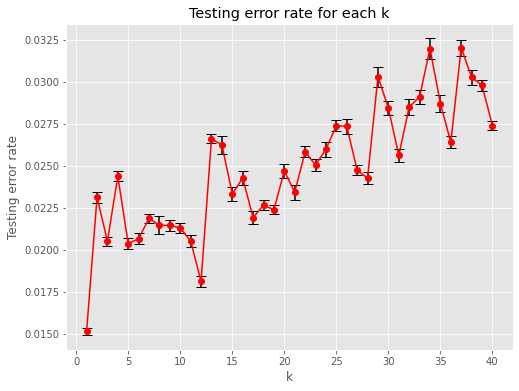

The confusion matrix for the 4 classes is: 
[[145   1   0   6]
 [  1 105   4   2]
 [  2   2 116   0]
 [  0   0   2  94]]

The number of the training samples correspondent to each class are: 84, 100, 104 and 116.
The number of the testing samples correspondent to each class are: 152, 112, 120 and 96.

  For class 0, the 2x2 confusion matrix is:
[[145   7]
 [  3 325]]

  For class 1, the 2x2 confusion matrix is:
[[105   7]
 [  3 365]]

  For class 2, the 2x2 confusion matrix is:
[[116   4]
 [  6 354]]

  For class 3, the 2x2 confusion matrix is:
[[ 94   2]
 [  8 376]]

The overall accuracy of the classifier is:  95.83333333333334


In [28]:
# Your code goes here.
import random
def get_indices(size, no_of_samples):
  """
  Function to build the testing samples for random sampling and returns the indices
  of the concated samples.
  """
  testing_samples = []
  indices = list(range(800))

  while(no_of_samples > 0):
      start_indice = random.randrange(0, 800 - size, size)
      testing_samples = testing_samples + indices[start_indice:(start_indice + size)]
      no_of_samples = no_of_samples - 1
  
  return testing_samples


k_range = 40
no_of_splits = 40
size = 12
no_of_tests = 20

testing_mean_error = []
testing_std = []

for k in range(1, k_range + 1):
    testing_error_rate = []

    for i in range(no_of_tests):

        indices_testing = get_indices(size, no_of_splits)
        indices_training = [i for i in list(range(800)) if i not in indices_testing]

        test_samples = data[indices_testing]
        training_data = data[indices_training]
        training_labels = labels[indices_training]
        testing_labels = labels[indices_testing]

        knn_result = knn_classify(test_samples, training_data, training_labels, "cosine", k)

        matches = sum((knn_result == testing_labels))

        testing_error_rate.append((1 - matches / (testing_labels.shape[0])) / no_of_splits)

    testing_mean_error.append(np.sum(testing_error_rate))
    testing_std.append(np.std(testing_error_rate))

print("The best k over all testing experiments is: ", np.argmin(testing_mean_error) + 1)

fig = plt.figure(figsize = (8, 6))

plt.errorbar(list(range(1, k_range + 1)), testing_mean_error, yerr=testing_std, color = "red", marker = "o", capsize = 5, capthick = 1, ecolor = "black")
plt.ylabel("Testing error rate")
plt.xlabel("k")
plt.title("Testing error rate for each k")
plt.show()

import collections

indices_testing = get_indices(size, no_of_splits)
indices_training = [i for i in list(range(800)) if i not in indices_testing]

test_samples = data[indices_testing]
training_data = data[indices_training]
training_labels = labels[indices_training]
testing_labels = labels[indices_testing]

knn_result = knn_classify(test_samples, training_data, training_labels, "cosine", np.argmin(testing_mean_error) + 1)

matches = sum((knn_result == testing_labels))

testing_size = size * no_of_splits
training_size = 800 - testing_size

indices  = list(range(testing_size))
confusion_matrix = np.zeros((4, 4))
for i in range(0,4):
  for j in range(0, 4):
    confusion_matrix[i][j] = sum(map(lambda k: testing_labels[k] == i and knn_result[k] == j, indices))

print("The confusion matrix for the 4 classes is: ")
confusion_matrix = confusion_matrix.astype(int)
print(confusion_matrix)

label_frequency = collections.Counter(training_labels)
print("\nThe number of the training samples correspondent to each class are: " + str(label_frequency[0]) + ", " + str(label_frequency[1]) + ", " + str(label_frequency[2]) + " and " + str(label_frequency[3]) + ".")
label_frequency = collections.Counter(testing_labels)
print("The number of the testing samples correspondent to each class are: " + str(label_frequency[0]) + ", " + str(label_frequency[1]) + ", " + str(label_frequency[2]) + " and " + str(label_frequency[3]) + ".")


for label in range(0,4):
  print("\n  For class " + str(label) + ", the 2x2 confusion matrix is:")
  tp = confusion_matrix[label][label]
  fp = confusion_matrix[label].sum() - tp
  fn = confusion_matrix[:, label].sum() - tp
  tn = confusion_matrix.sum() - fp - fn - tp
  print(np.array([[tp, fp],[fn, tn]]))

print("\nThe overall accuracy of the classifier is: ", np.trace(confusion_matrix) / testing_size * 100)